In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import datetime
import itertools
import matplotlib.dates as mdates
from scipy.optimize import curve_fit
import matplotlib.ticker as ticker
import time

In [2]:
#print(plt.style.available)
plt.style.use('seaborn-poster')

In [3]:
def get_data():
    ##Get data from the source that is used to generate map (based on WHO official data):
    ##https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html?fbclid=IwAR0oKIKJlc-zeNZGFBVEN0-O-58daoCDaKicXwC10cjFWgCZqTPgavseTfI#/bda7594740fd40299423467b48e9ecf6
    url_confirmed = "https://raw.github.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
    url_deaths = "https://raw.github.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
    url_recovered = "https://raw.github.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"        
    for url, data_type in zip([url_confirmed, url_deaths, url_recovered], ["confirmed", "deaths", "recovered"]):
    
        r = requests.get(url)
        filename=data_type+".csv"
        f = open(filename,'wb')
        f.write(r.content)

In [4]:
get_data()

In [5]:
## prepare dataset
confirmed = pd.read_csv("confirmed.csv")
deaths = pd.read_csv("deaths.csv")
recovered = pd.read_csv("recovered.csv")

def reshape_single_dataset(data):
    data=data.drop(columns=["Province/State", "Lat", "Long"])
    ## aggregate data for each country
    data=data.groupby("Country/Region").sum().reset_index()
    ## reshape data
    data.reset_index(drop=True, inplace=True)
    data=data.set_index("Country/Region")
    #data=data.transpose().reset_index().rename(columns={'index':'Date'})
    #data['Date'] = pd.to_datetime(data['Date'])
    
    return data

confirmed = reshape_single_dataset(confirmed)
deaths = reshape_single_dataset(deaths)
recovered = reshape_single_dataset(recovered)

inactive=deaths.add(recovered)

confirmed=confirmed.transpose().reset_index().rename(columns={'index':'Date'})
confirmed['Date'] = pd.to_datetime(confirmed['Date'])

inactive=inactive.transpose().reset_index().rename(columns={'index':'Date'})
inactive['Date'] = pd.to_datetime(inactive['Date'])

distance = inactive.copy()

In [6]:
#distance

In [7]:
# extract data for each country, divide by population and multiply by the value of per_num
dates=confirmed["Date"].values
dates_num = mdates.date2num(dates)
dates_start = np.min(dates_num)
dates_num = dates_num - dates_start

days_to_extrapolate=40
dates_num_extrapolate = np.arange(0,len(dates_num)+days_to_extrapolate,1)

all_countries = inactive.columns[1:]

def get_day_closest_to_value(searched, country):
    df_sort = confirmed.iloc[(confirmed[country]-searched).abs().argsort()[:1]]
    index = df_sort[country].index.values[0]
    #print(confirmed.loc[index, "Date"])
    return index


for country in all_countries:
    distance[country] = inactive[country].apply(lambda x: get_day_closest_to_value(x,country) if x > 0 else np.nan)
    


In [8]:
distance = distance.reset_index()

In [9]:
distance = distance[all_countries].sub(distance['index'], axis=0)

In [10]:
distance

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,-31.0,-18.0,-22.0,-15.0,-21.0,-34.0,-25.0,-23.0,-36.0,-14.0,...,-74.0,-12.0,-11.0,-27.0,-25.0,-27.0,4.0,-8.0,-7.0,-22.0
148,-29.0,-19.0,-22.0,-16.0,-22.0,-35.0,-26.0,-22.0,-37.0,-14.0,...,-75.0,-13.0,-12.0,-28.0,-26.0,-28.0,3.0,-9.0,-8.0,-23.0
149,-29.0,-17.0,-22.0,-17.0,-22.0,-36.0,-25.0,-21.0,-38.0,-14.0,...,-76.0,-14.0,-12.0,-29.0,-25.0,-23.0,2.0,-10.0,-10.0,-24.0
150,-30.0,-18.0,-22.0,-18.0,-23.0,-37.0,-25.0,-20.0,-38.0,-15.0,...,-77.0,-14.0,-13.0,-30.0,-25.0,-24.0,1.0,-9.0,-11.0,-25.0


In [11]:
distance = distance[all_countries].multiply(-1, axis=0)

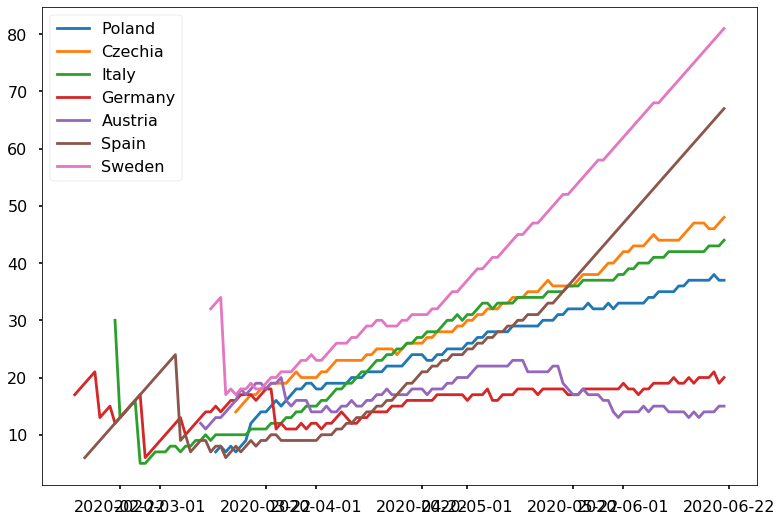

In [12]:
countries_to_plot=['Poland', 'Czechia', 'Italy', 'Germany', 'Austria', 'Spain', 'Sweden']

for country in countries_to_plot:
    plt.plot(dates, distance[country], label = country)
    plt. legend()

In [13]:
N=7
confirmed_derivative_ave = confirmed[all_countries].diff(periods=N)
inactive_derivative_ave = inactive[all_countries].diff(periods=N)

confirmed_derivative = confirmed[all_countries].diff(periods=1)
inactive_derivative = inactive[all_countries].diff(periods=1)


In [14]:
derivatives_ratio = confirmed_derivative.div(inactive_derivative)
derivatives_ratio_ave = confirmed_derivative_ave.div(inactive_derivative_ave)

In [15]:
inactive_derivative["Poland"]

0        NaN
1        0.0
2        0.0
3        0.0
4        0.0
       ...  
147    281.0
148    426.0
149    399.0
150    495.0
151    512.0
Name: Poland, Length: 152, dtype: float64

In [16]:
confirmed_derivative["Poland"]

0        NaN
1        0.0
2        0.0
3        0.0
4        0.0
       ...  
147    506.0
148    314.0
149    301.0
150    304.0
151    311.0
Name: Poland, Length: 152, dtype: float64

In [17]:
confirmed_derivative["Poland"].div(inactive_derivative["Poland"])

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
147    1.800712
148    0.737089
149    0.754386
150    0.614141
151    0.607422
Name: Poland, Length: 152, dtype: float64

75
56.705882352941174


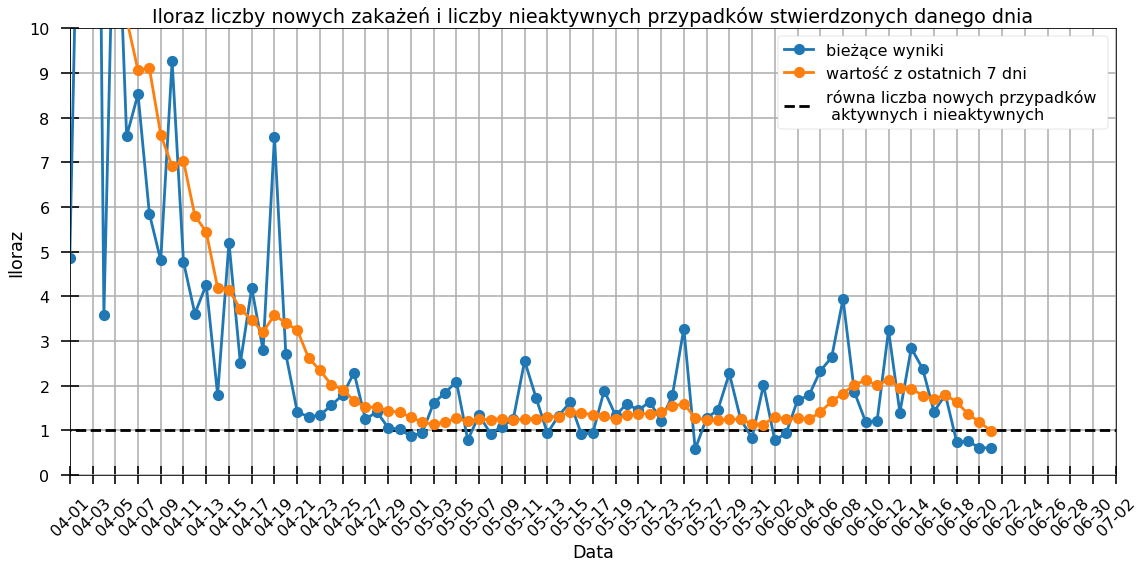

In [18]:
def exponent(x, a, b, c):
    return a * np.exp(b * (x-c))

countries_to_plot=['Poland']
rolling = derivatives_ratio.rolling(N, win_type ='triang').mean()

fig, axis = plt.subplots(1,1, figsize=(16, 8), )

x_dates = mdates.num2date(dates_num_extrapolate+dates_start)


for country in countries_to_plot:
    axis.plot(dates, derivatives_ratio[country], label = "bieżące wyniki", marker="o",)
    axis.plot(dates, derivatives_ratio_ave[country], label = "wartość z ostatnich 7 dni", marker="o", zorder=10)
    
    axis.hlines(1, x_dates[0], x_dates[-1], linestyles='--', label='równa liczba nowych przypadków \n aktywnych i nieaktywnych')
    
    y = derivatives_ratio_ave[country]
    y[y == np.inf] = 0
    
    fit_start=(np.nanargmax(y))+12
    print(fit_start)
    print(y[65])
    
    popt, pcov = curve_fit(exponent, dates_num[fit_start:], y[fit_start:], maxfev=10000)
    fit = exponent(dates_num_extrapolate[fit_start:], *popt)
    #axis.plot(mdates.num2date(dates_num_extrapolate[fit_start:]+dates_start), fit, label="dopasowanie zanik wykładniczy")
    
    fit_start=(np.nanargmax(y))+20
    0
    popt, pcov = curve_fit(exponent, dates_num[fit_start:], y[fit_start:], maxfev=10000)
    fit = exponent(dates_num_extrapolate[fit_start:], *popt)
    #axis.plot(mdates.num2date(dates_num_extrapolate[fit_start:]+dates_start), fit, label="dopasowanie zanik wykładniczy")
    
    
    
    
    tick_spacing=2
    axis.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    axis.xaxis.set_tick_params(rotation=45, direction="out")

    tick_spacing=1
    axis.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    date_form = DateFormatter("%m-%d")
    axis.xaxis.set_major_formatter(date_form)
    axis.tick_params(direction='inout', length=18, colors='k')  
    
    axis.grid(True)
    
    ## axes limits
    axis.set_xlim([datetime.date(2020, 4, 1), datetime.date.today() + datetime.timedelta(days=days_to_extrapolate-30)])# datetime.date(2020, 3, 15)])
    axis.legend()
    axis.set_ylim([-0,10])
    #axis.set_yscale("log")
    legend = axis.legend(frameon=1, facecolor='white', framealpha=1, fontsize=16, handlelength=1.8)#, loc='upper left')

    
axis.set(xlabel="Data",
       ylabel="Iloraz",
       title="Iloraz liczby nowych zakażeń i liczby nieaktywnych przypadków stwierdzonych danego dnia")    

fig.tight_layout()
plt.show()

timestamp=time.strftime("%Y_%m_%d")
fig.savefig("./predictions_for_poland_figures/ratio_aktywne_nieaktywne_"+timestamp+".png")





In [19]:
print(derivatives_ratio[country][-25:])

127    1.466667
128    2.275862
129    1.245509
130    0.833333
131    2.015957
132    0.779661
133    0.938907
134    1.679070
135    1.783251
136    2.331984
137    2.637615
138    3.940789
139    1.860465
140    1.184874
141    1.221088
142    3.241379
143    1.401274
144    2.840909
145    2.385542
146    1.418118
147    1.800712
148    0.737089
149    0.754386
150    0.614141
151    0.607422
Name: Poland, dtype: float64


In [20]:
dates_num[fit_start:]

array([ 83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,
        94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104.,
       105., 106., 107., 108., 109., 110., 111., 112., 113., 114., 115.,
       116., 117., 118., 119., 120., 121., 122., 123., 124., 125., 126.,
       127., 128., 129., 130., 131., 132., 133., 134., 135., 136., 137.,
       138., 139., 140., 141., 142., 143., 144., 145., 146., 147., 148.,
       149., 150., 151.])

In [21]:
derivatives_ratio_ave["Poland"].values[-10:]

array([2.13986486, 1.95927602, 1.93771389, 1.78169492, 1.7032967 ,
       1.79811321, 1.63414634, 1.36608479, 1.19075938, 0.98947779])